(kalman)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Another Look at the Kalman Filter

```{index} single: Kalman Filter 2
```

```{contents} Contents
:depth: 2
```

In this quantecon lecture {doc}`A First Look at the Kalman filter <kalman>`, we used
a Kalman filter to estimate  locations of a rocket. 

In this lecture,  we'll use the Kalman filter to 
infer a worker's human capital and the  effort that the worker devotes to accumulating 
human capital, neither of which the firm observes directly.

The firm learns about those things only by observing a history of the output that the worker generates for the firm, and from understanding how that output depends on the worker's human capital and how human capital evolves as a function of the worker's effort. 

We'll posit a rule that expresses how the much  firm pays the worker each period  as a function of the firm's information each period.

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

To conduct simulations, we bring in these imports, as in {doc}`A First Look at the Kalman filter <kalman>`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon import Kalman, LinearStateSpace
from collections import namedtuple
from scipy.stats import multivariate_normal
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

## A worker's output 

A representative worker is permanently employed at a firm.

The workers'  output  is  described by the following dynamic process:

```{math}
:label: worker_model

\begin{aligned}
h_{t+1} &= \alpha h_t + \beta u_t + c w_{t+1}, \quad c_{t+1} \sim {\mathcal N}(0,1) \\
u_{t+1} & = u_t \\
y_t & = g h_t + v_t , \quad v_t \sim {\mathcal N} (0, R)
\end{aligned}
```

Here 

* $h_t$ is the logarithm of human capital at time $t$
* $u_t$ is the logarithm of the worker's effort at accumulating human capital at $t$ 
* $y_t$ is the logarithm of the worker's output at time $t$
* $h_0 \sim {\mathcal N}(\hat h_0, \sigma_{h,0})$
* $u_0 \sim {\mathcal N}(\hat u_0, \sigma_{u,0})$

Parameters of the model are $\alpha, \beta, c, R, g, \hat h_0, \hat u_0, \sigma_h, \sigma_u$.

At time $0$, a firm has hired the worker.

The worker is permanently attached to the firm and so works for the same  firm at all  dates $t =0, 1, 2, \ldots$.

At the beginning of time $0$, the firm observes neither the worker's innate initial human capital $h_0$ nor its hard-wired permanent effort level $u_0$.

The firm believes that $u_0$ for a particular worker is drawn from a Gaussian probability distribution, and so is  described by $u_0 \sim {\mathcal N}(\hat u_0, \sigma_{u,0})$.

The $h_t$ part of a worker's "type" moves over time, but the effort component of the worker's  type is  $u_t = u_0$.

This means that  from the firm's point of view, the worker's effort is  effectively an unknown  fixed  "parameter".

At time $t\geq 1$, for a particular worker the  firm  observed  $y^{t-1} = [y_{t-1}, y_{t-2}, \ldots, y_0]$.

The firm does not observe the  worker's "type" $(h_0, u_0)$.

But the firm  does observe the worker's  output $y_t$ at time $t$ and remembers the worker's past outputs $y^{t-1}$.

## A firm's wage-setting policy

Based on information about the worker that the firm has at time $t \geq 1$, the firm pays the worker log wage  

$$
w_t = g  E [ h_t | y^{t-1} ], \quad t \geq 1
$$

and at time $0$ pays the  worker a log wage equal to  the unconditional mean of $y_0$:

$$
w_0 = g \hat h_0
$$

In using this payment rule, the firm is taking into account that the worker's log output today is partly due
to the random component $v_t$ that comes entirely from luck, and that is assumed to be independent of $h_t$ and $u_t$.


## A state-space representation

Write system [](worker_model) in the state-space form

```{math}
\begin{aligned}
\begin{bmatrix} h_{t+1} \cr u_{t+1} \end{bmatrix} &= \begin{bmatrix} \alpha & \beta \cr 0 & 1 \end{bmatrix}\begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} + \begin{bmatrix} c \cr 0 \end{bmatrix} w_{t+1} \cr
y_t & = \begin{bmatrix} g & 0 \end{bmatrix} \begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} + v_t
\end{aligned}
```

which is equivalent with

```{math}
:label: ssrepresent
\begin{aligned} 
x_{t+1} & = A x_t + C w_{t+1} \cr
y_t & = G x_t + v_t \cr
x_0 & \sim {\mathcal N}(\hat x_0, \Sigma_0) 
\end{aligned}
```

where

```{math}
x_t  = \begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} , \quad
\hat x_0  = \begin{bmatrix} \hat h_0 \cr \hat u_0 \end{bmatrix} , \quad
\Sigma_0  = \begin{bmatrix} \sigma_{h,0} & 0 \cr
                     0 & \sigma_{u,0} \end{bmatrix}
```

To compute the firm's wage setting policy, we first we create a `namedtuple` to store the parameters of the model

In [3]:
WorkerModel = namedtuple("WorkerModel", 
                ('A', 'C', 'G', 'R', 'xhat_0', 'Σ_0'))

def create_worker(α=.8, β=.2, c=.2,
                  R=.5, g=1.0, hhat_0=4, uhat_0=4, 
                  σ_h=4, σ_u=4):
    
    A = np.array([[α, β], 
                  [0, 1]])
    C = np.array([[c], 
                  [0]])
    G = np.array([g, 1])

    # Define initial state and covariance matrix
    xhat_0 = np.array([[hhat_0], 
                       [uhat_0]])
    
    Σ_0 = np.array([[σ_h, 0],
                    [0, σ_u]])
    
    return WorkerModel(A=A, C=C, G=G, R=R, xhat_0=xhat_0, Σ_0=Σ_0)

Please note how the `WorkerModel` namedtuple creates all of the objects required to compute an associated
state-space representation {eq}`ssrepresent`.

This is handy, because in order to  simulate a history $\{y_t, h_t\}$ for a worker, we'll want to form 
 state space system for him/her by using the [`LinearStateSpace`](https://quanteconpy.readthedocs.io/en/latest/tools/lss.html) class.

In [4]:
# Define A, C, G, R, xhat_0, Σ_0
worker = create_worker()
A, C, G, R = worker.A, worker.C, worker.G, worker.R
xhat_0, Σ_0 = worker.xhat_0, worker.Σ_0

# Create a LinearStateSpace object
ss = LinearStateSpace(A, C, G, np.sqrt(R), 
        mu_0=xhat_0, Sigma_0=np.zeros((2,2)))

T = 100
x, y = ss.simulate(T)
y = y.flatten()

h_0, u_0 = x[0, 0], x[1, 0]

Next, to  compute the firm's policy for setting the log wage based on the information it has about the worker,
we  use the Kalman filter described in this quantecon lecture {doc}`A First Look at the Kalman filter <kalman>`.

In particular, we want to compute all of the objects in an "innovation representation".

## An Innovations Representation

We have all the objects in hand required to form an innovations representation for the output
process $\{y_t\}_{t=0}^T$ for a worker.

Let's code that up now.

```{math}
\begin{aligned}
\hat x_{t+1} & = A \hat x_t + K_t a_t \cr
y_{t} & = G \hat x_t + a_t
\end{aligned}
```
where $K_t$ is the Kalman gain matrix at time $t$.


We accomplish this in the following code that  uses the [`Kalman`](https://quanteconpy.readthedocs.io/en/latest/tools/kalman.html) class.

In [5]:
kalman = Kalman(ss, xhat_0, Σ_0)
Σ_t = np.zeros((*Σ_0.shape, T-1))
y_hat_t = np.zeros(T-1)
x_hat_t = np.zeros((2, T-1))

for t in range(1, T):
    kalman.update(y[t])
    x_hat, Σ = kalman.x_hat, kalman.Sigma
    Σ_t[:, :, t-1] = Σ
    x_hat_t[:, t-1] = x_hat.reshape(-1)
    y_hat_t[t-1] = worker.G @ x_hat

x_hat_t = np.concatenate((x[:, 1][:, np.newaxis], 
                    x_hat_t), axis=1)
Σ_t = np.concatenate((worker.Σ_0[:, :, np.newaxis], 
                    Σ_t), axis=2)
u_hat_t = x_hat_t[1, :]

For a draw of $h_0, u_0$,  we plot $E y_t = G \hat x_t $ where $\hat x_t = E [x_t | y^{t-1}]$.

We also plot $E [u_0 | y^{t-1}]$, which is  the firm inference about  a worker's hard-wired "work ethic" $u_0$, conditioned on information $y^{t-1}$ that it has about him or her coming into period $t$.

We can  watch as the  firm's inference  $E [u_0 | y^{t-1}]$ of the worker's work ethic converges toward the hidden   $u_0$, which is not directly observed by the firm.

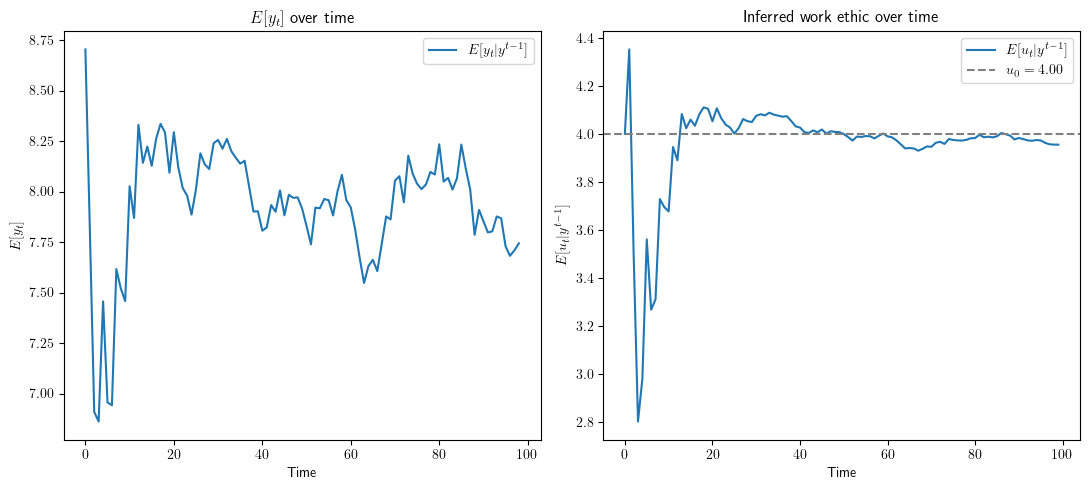

In [6]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(y_hat_t, label=r'$E[y_t| y^{t-1}]$')
ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$E[y_t]$')
ax[0].set_title(r'$E[y_t]$ over time')
ax[0].legend()

ax[1].plot(u_hat_t, label=r'$E[u_t|y^{t-1}]$')
ax[1].axhline(y=u_0, color='grey', 
            linestyle='dashed', label=fr'$u_0={u_0:.2f}$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$E[u_t|y^{t-1}]$')
ax[1].set_title('Inferred work ethic over time')
ax[1].legend()

fig.tight_layout()
plt.show()

## Some Computational Experiments

Let's look at  $\Sigma_0$ and $\Sigma_T$ in order to see how much the firm learns about the hidden state during the horizon we have set.

In [7]:
print(Σ_t[:, :, 0])

[[4. 0.]
 [0. 4.]]


In [8]:
print(Σ_t[:, :, -1])

[[0.08805027 0.00100377]
 [0.00100377 0.00398351]]


Evidently,  entries in the conditional covariance matrix become smaller over time.

It is enlightening to  portray how  conditional covariance matrices $\Sigma_t$ evolve by plotting confidence ellipsoides around $E [x_t |y^{t-1}] $ at various $t$'s.

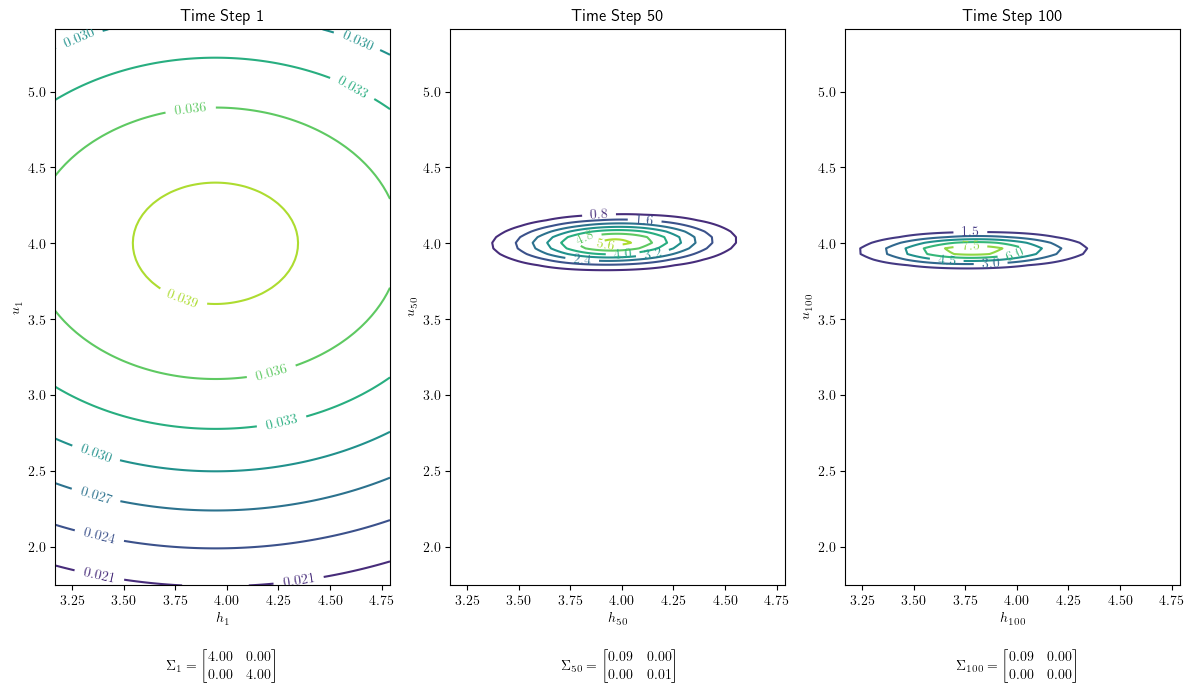

In [9]:
# Create a grid of points for contour plotting
h_range = np.linspace(x_hat_t[0, :].min()-0.5*Σ_t[0, 0, 1], 
                      x_hat_t[0, :].max()+0.5*Σ_t[0, 0, 1], 100)
u_range = np.linspace(x_hat_t[1, :].min()-0.5*Σ_t[1, 1, 1], 
                      x_hat_t[1, :].max()+0.5*Σ_t[1, 1, 1], 100)
h, u = np.meshgrid(h_range, u_range)

# Create a figure with subplots for each time step
fig, axs = plt.subplots(1, 3, figsize=(12, 7))

# Iterate through each time step
for i, t in enumerate(np.linspace(0, T-1, 3, dtype=int)):
    # Create a multivariate normal distribution with x_hat and Σ at time step t
    mu = x_hat_t[:, t]
    cov = Σ_t[:, :, t]
    mvn = multivariate_normal(mean=mu, cov=cov)
    
    # Evaluate the multivariate normal PDF on the grid
    pdf_values = mvn.pdf(np.dstack((h, u)))
    
    # Create a contour plot for the PDF
    con = axs[i].contour(h, u, pdf_values, cmap='viridis')
    axs[i].clabel(con, inline=1, fontsize=10)
    axs[i].set_title(f'Time Step {t+1}')
    axs[i].set_xlabel(r'$h_{{{}}}$'.format(str(t+1)))
    axs[i].set_ylabel(r'$u_{{{}}}$'.format(str(t+1)))
    
    cov_latex = r'$\Sigma_{{{}}}= \begin{{bmatrix}} {:.2f} & {:.2f} \\ {:.2f} & {:.2f} \end{{bmatrix}}$'.format(
        t+1, cov[0, 0], cov[0, 1], cov[1, 0], cov[1, 1]
    )
    axs[i].text(0.33, -0.15, cov_latex, transform=axs[i].transAxes)

    
plt.tight_layout()
plt.show()

Note how the accumulation of evidence $y^t$ affects the shape of the confidence ellipsoid as sample size $t$ grows. 

Now let's use our code to set the hidden state $x_0$ to a particular vector in order to watch how
a firm learns starting from some $x_0$ we are interested in. 

For example, let's say $h_0 = 0$ and $u_0 = 4$.

Here is one way to do this.

In [10]:
# For example, we might want h_0 = 0 and u_0 = 4
mu_0 = np.array([0.0, 4.0])

# Create a LinearStateSpace object with Sigma_0 as a matrix of zeros
ss_example = LinearStateSpace(A, C, G, np.sqrt(R), mu_0=mu_0, 
                              # This line forces exact h_0=0 and u_0=4
                              Sigma_0=np.zeros((2, 2))
                             )

T = 100
x, y = ss_example.simulate(T)
y = y.flatten()

# Now h_0=0 and u_0=4
h_0, u_0 = x[0, 0], x[1, 0]
print('h_0 =', h_0)
print('u_0 =', u_0)

h_0 = 0.0
u_0 = 4.0


Another way to accomplish the same goal is to use the following code.

In [11]:
# If we want to set the initial 
# h_0 = hhat_0 = 0 and u_0 = uhhat_0 = 4.0:
worker = create_worker(hhat_0=0.0, uhat_0=4.0)

ss_example = LinearStateSpace(A, C, G, np.sqrt(R), 
                              # This line takes h_0=hhat_0 and u_0=uhhat_0
                              mu_0=worker.xhat_0,
                              # This line forces exact h_0=hhat_0 and u_0=uhhat_0
                              Sigma_0=np.zeros((2, 2))
                             )

T = 100
x, y = ss_example.simulate(T)
y = y.flatten()

# Now h_0 and u_0 will be exactly hhat_0
h_0, u_0 = x[0, 0], x[1, 0]
print('h_0 =', h_0)
print('u_0 =', u_0)

h_0 = 0.0
u_0 = 4.0


For this worker, let's generate a plot like the one above.

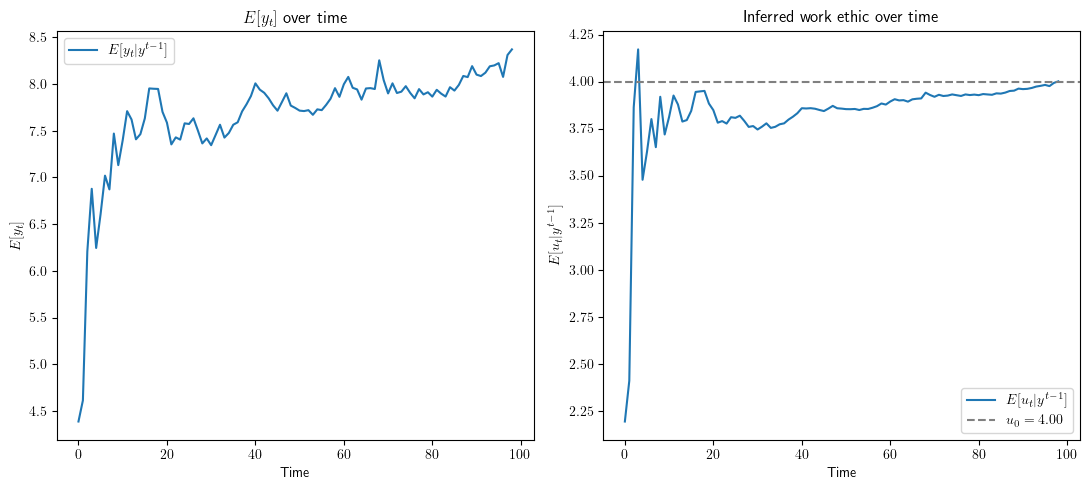

In [12]:
# First we compute the Kalman filter with initial xhat_0 and Σ_0 
kalman = Kalman(ss, xhat_0, Σ_0)
Σ_t = []
y_hat_t = np.zeros(T-1)
u_hat_t = np.zeros(T-1)

# Then we iteratively update the Kalman filter class using 
# observation y based on the linear state model above:
for t in range(1, T):
    kalman.update(y[t])
    x_hat, Σ = kalman.x_hat, kalman.Sigma
    Σ_t.append(Σ)
    y_hat_t[t-1] = worker.G @ x_hat
    u_hat_t[t-1] = x_hat[1]


# Generate plots for y_hat_t and u_hat_t
fig, ax = plt.subplots(1, 2)

ax[0].plot(y_hat_t, label=r'$E[y_t| y^{t-1}]$')
ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$E[y_t]$')
ax[0].set_title(r'$E[y_t]$ over time')
ax[0].legend()

ax[1].plot(u_hat_t, label=r'$E[u_t|y^{t-1}]$')
ax[1].axhline(y=u_0, color='grey', 
            linestyle='dashed', label=fr'$u_0={u_0:.2f}$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$E[u_t|y^{t-1}]$')
ax[1].set_title('Inferred work ethic over time')
ax[1].legend()

fig.tight_layout()
plt.show()

More generally, we can change some or all of the parameters defining a worker in our `create_worker`
namedtuple.

Here is an example.

In [13]:
# We can set these parameters when creating a worker -- just like classes!
hard_working_worker =  create_worker(α=.4, β=.8, 
                        hhat_0=7.0, uhat_0=100, σ_h=2.5, σ_u=3.2)

print(hard_working_worker)

WorkerModel(A=array([[0.4, 0.8],
       [0. , 1. ]]), C=array([[0.2],
       [0. ]]), G=array([1., 1.]), R=0.5, xhat_0=array([[  7.],
       [100.]]), Σ_0=array([[2.5, 0. ],
       [0. , 3.2]]))


We can also simulate the system for $T = 50$ periods for different workers.

The difference between the inferred work ethics and true work ethics converges to $0$ over time.

This shows that the filter is gradually teaching the worker and firm about the worker's effort.

In [14]:
def simulate_workers(worker, T, ax, mu_0=None, Sigma_0=None, 
                    diff=True, name=None, title=None):
    A, C, G, R = worker.A, worker.C, worker.G, worker.R
    xhat_0, Σ_0 = worker.xhat_0, worker.Σ_0
    
    if isinstance(mu_0, type(None)):
        mu_0 = xhat_0
    if isinstance(Sigma_0, type(None)):
        Sigma_0 = worker.Σ_0
        
    ss = LinearStateSpace(A, C, G, np.sqrt(R), 
                        mu_0=mu_0, Sigma_0=Sigma_0)

    x, y = ss.simulate(T)
    y = y.flatten()

    u_0 = x[1, 0]
    
    # Compute Kalman filter
    kalman = Kalman(ss, xhat_0, Σ_0)
    Σ_t = []
    
    y_hat_t = np.zeros(T)
    u_hat_t = np.zeros(T)

    for i in range(T):
        kalman.update(y[i])
        x_hat, Σ = kalman.x_hat, kalman.Sigma
        Σ_t.append(Σ)
        y_hat_t[i] = worker.G @ x_hat
        u_hat_t[i] = x_hat[1]

    if diff == True:
        title = ('Difference between inferred and true work ethic over time' 
                 if title == None else title)
        
        ax.plot(u_hat_t - u_0, alpha=.5)
        ax.axhline(y=0, color='grey', linestyle='dashed')
        ax.set_xlabel('Time')
        ax.set_ylabel(r'$E[u_t|y^{t-1}] - u_0$')
        ax.set_title(title)
        
    else:
        label_line = (r'$E[u_t|y^{t-1}]$' if name == None 
                      else name)
        title = ('Inferred work ethic over time' 
                if title == None else title)
        
        u_hat_plot = ax.plot(u_hat_t, label=label_line)
        ax.axhline(y=u_0, color=u_hat_plot[0].get_color(), 
                    linestyle='dashed', alpha=0.5)
        ax.set_xlabel('Time')
        ax.set_ylabel(r'$E[u_t|y^{t-1}]$')
        ax.set_title(title)

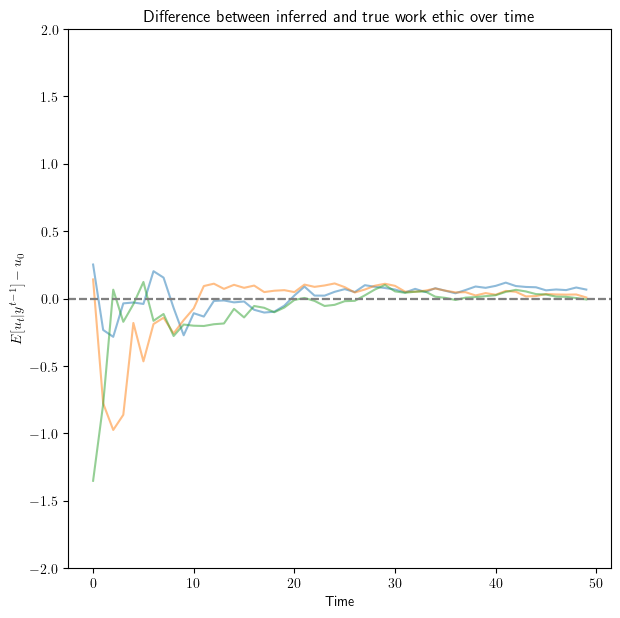

In [15]:
num_workers = 3
T = 50
fig, ax = plt.subplots(figsize=(7, 7))

for i in range(num_workers):
    worker = create_worker(uhat_0=4+2*i)
    simulate_workers(worker, T, ax)
ax.set_ylim(ymin=-2, ymax=2)
plt.show()

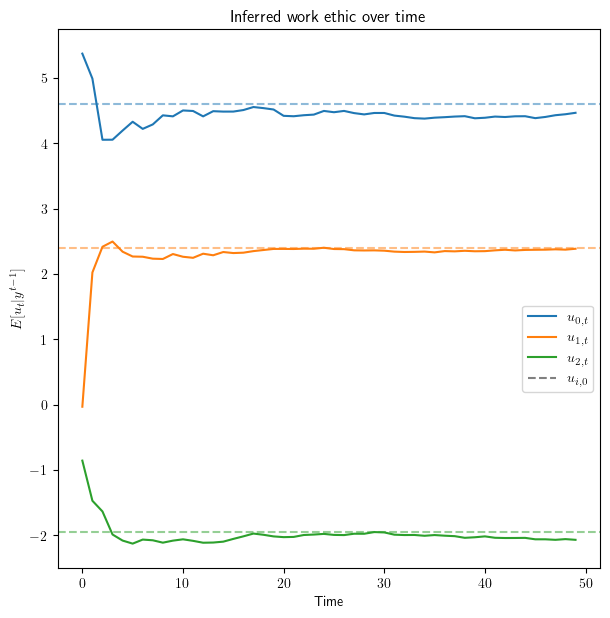

In [16]:
# We can also generate plots of u_t:

T = 50
fig, ax = plt.subplots(figsize=(7, 7))

uhat_0s = [2, -2, 1]
αs = [0.2, 0.3, 0.5]
βs = [0.1, 0.9, 0.3]

for i, (uhat_0, α, β) in enumerate(zip(uhat_0s, αs, βs)):
    worker = create_worker(uhat_0=uhat_0, α=α, β=β)
    simulate_workers(worker, T, ax,
                    # By setting diff=False, it will give u_t
                    diff=False, name=r'$u_{{{}, t}}$'.format(i))
    
ax.axhline(y=u_0, xmin=0, xmax=0, color='grey', 
           linestyle='dashed', label=r'$u_{i, 0}$')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

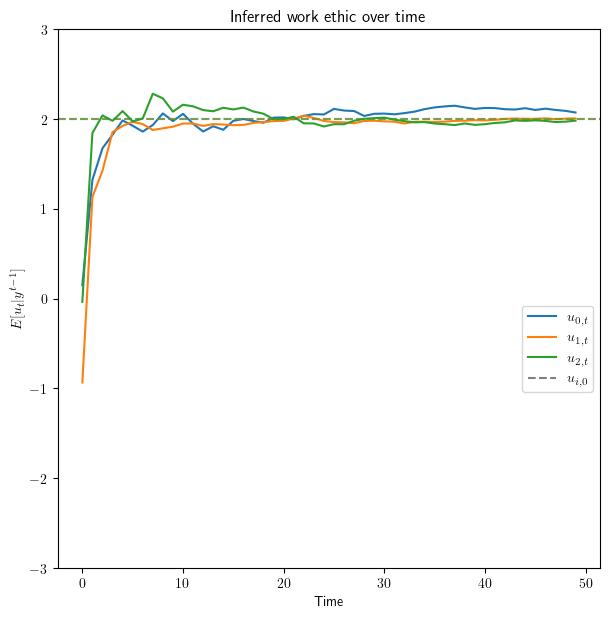

In [17]:
# We can also use exact u_0=1 and h_0=2 for all workers

T = 50
fig, ax = plt.subplots(figsize=(7, 7))

# These two lines set u_0=1 and h_0=2 for all workers
mu_0 = np.array([[1],
                 [2]])
Sigma_0 = np.zeros((2,2))

uhat_0s = [2, -2, 1]
αs = [0.2, 0.3, 0.5]
βs = [0.1, 0.9, 0.3]

for i, (uhat_0, α, β) in enumerate(zip(uhat_0s, αs, βs)):
    worker = create_worker(uhat_0=uhat_0, α=α, β=β)
    simulate_workers(worker, T, ax, mu_0=mu_0, Sigma_0=Sigma_0, 
                     diff=False, name=r'$u_{{{}, t}}$'.format(i))
    
# This controls the boundary of plots
ax.set_ylim(ymin=-3, ymax=3)
ax.axhline(y=u_0, xmin=0, xmax=0, color='grey', 
           linestyle='dashed', label=r'$u_{i, 0}$')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

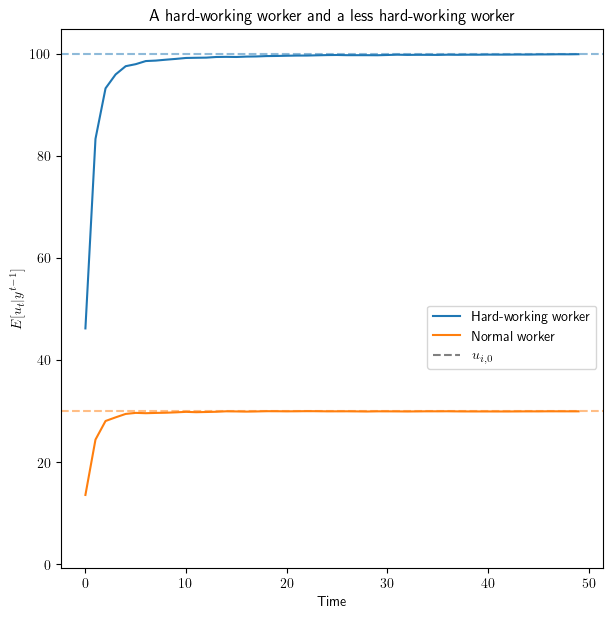

In [18]:
# We can generate a plot for only one of the workers:

T = 50
fig, ax = plt.subplots(figsize=(7, 7))

mu_0_1 = np.array([[1],
                 [100]])
mu_0_2 = np.array([[1],
                 [30]])
Sigma_0 = np.zeros((2,2))

uhat_0s = 100
αs = 0.5
βs = 0.3

worker = create_worker(uhat_0=uhat_0, α=α, β=β)
simulate_workers(worker, T, ax, mu_0=mu_0_1, Sigma_0=Sigma_0, 
                 diff=False, name=r'Hard-working worker')
simulate_workers(worker, T, ax, mu_0=mu_0_2, Sigma_0=Sigma_0, 
                 diff=False, 
                 title='A hard-working worker and a less hard-working worker',
                 name=r'Normal worker')
ax.axhline(y=u_0, xmin=0, xmax=0, color='grey', 
           linestyle='dashed', label=r'$u_{i, 0}$')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## Future Extensions

We can do lots of enlightening experiments by creating new types of workers and letting the firm 
learn about their hidden (to the firm) states by observing just their output histories.